In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import joblib

# === Step 1: Load and Preprocess Dataset ===
# Load dataset
data = pd.read_csv("ledger.csv")
data['date'] = pd.to_datetime(data['date'])

# Feature engineering
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Encode categorical features
label_encoders = {}
for col in ['project', 'ledger', 'company']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Create a combined feature for `project_ledger_company`
data['project_ledger_company'] = (
    data['project'].astype(str) + "_" + data['ledger'].astype(str) + "_" + data['company'].astype(str)
)
le_combined = LabelEncoder()
data['project_ledger_company'] = le_combined.fit_transform(data['project_ledger_company'])
label_encoders['project_ledger_company'] = le_combined

# Add lagged features
for lag in range(1, 4):
    data[f'lag_{lag}'] = data['dr_cr'].shift(lag)

# Add rolling statistics
data['rolling_mean_3'] = data['dr_cr'].rolling(window=3).mean()
data['rolling_sum_3'] = data['dr_cr'].rolling(window=3).sum()
data['rolling_std_3'] = data['dr_cr'].rolling(window=3).std()

# Drop rows with NaN values
data.dropna(inplace=True)

# Remove outliers using IQR
Q1 = data['dr_cr'].quantile(0.25)
Q3 = data['dr_cr'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['dr_cr'] = np.clip(data['dr_cr'], lower_bound, upper_bound)

# Prepare features and target
X = data[['project', 'ledger', 'company', 'year', 'month', 'day', 'project_ledger_company',
          'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_sum_3', 'rolling_std_3']]
y = data['dr_cr']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# === Step 2: Train the Model ===
# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)
xgb_model.fit(X_train, y_train)

# Save the model and encoders
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

# Evaluate the model
y_pred = xgb_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"XGBoost - Mean Squared Error: {mse}")
print(f"XGBoost - Mean Absolute Error: {mae}")
print(f"XGBoost - R-squared: {r2}")

XGBoost - Mean Squared Error: 805847234.6043651
XGBoost - Mean Absolute Error: 13528.426727750844
XGBoost - R-squared: 0.9425176198252654


In [7]:
# === Step 3: Forecast Pipeline ===
def forecast(input_date, input_project, input_ledger, input_company):
    # Load model and encoders
    xgb_model = joblib.load('xgboost_model.pkl')
    label_encoders = joblib.load('label_encoders.pkl')

    # Encode categorical inputs
    for col, value in zip(['project', 'ledger', 'company'], [input_project, input_ledger, input_company]):
        if col in label_encoders:
            locals()[col] = label_encoders[col].transform([value])[0]
        else:
            raise ValueError(f"Encoder for {col} not found!")

    # Encode combined feature
    combined_feature = f"{input_project}_{input_ledger}_{input_company}"
    if 'project_ledger_company' in label_encoders:
        project_ledger_company = label_encoders['project_ledger_company'].transform([combined_feature])[0]
    else:
        raise ValueError("Encoder for project_ledger_company not found!")

    # Filter historical data up to the input date
    historical_data = data[data['date'] < input_date].copy()

    # Ensure historical data has all necessary columns
    if historical_data.empty:
        raise ValueError("Insufficient historical data to compute lagged features and rolling statistics.")

    # Sort historical data by date
    historical_data.sort_values(by='date', inplace=True)

    # Compute lagged features and rolling statistics
    lagged_features = {}
    for lag in range(1, 4):
        lagged_features[f'lag_{lag}'] = historical_data['dr_cr'].iloc[-lag] if len(historical_data) >= lag else 0

    rolling_window = historical_data['dr_cr'].iloc[-3:] if len(historical_data) >= 3 else historical_data['dr_cr']
    rolling_mean_3 = rolling_window.mean()
    rolling_sum_3 = rolling_window.sum()
    rolling_std_3 = rolling_window.std()

    # Prepare input for prediction
    input_features = pd.DataFrame([{
        'project': locals().get('project'),
        'ledger': locals().get('ledger'),
        'company': locals().get('company'),
        'year': pd.to_datetime(input_date).year,
        'month': pd.to_datetime(input_date).month,
        'day': pd.to_datetime(input_date).day,
        'project_ledger_company': project_ledger_company,
        'lag_1': lagged_features.get('lag_1', 0),
        'lag_2': lagged_features.get('lag_2', 0),
        'lag_3': lagged_features.get('lag_3', 0),
        'rolling_mean_3': rolling_mean_3,
        'rolling_sum_3': rolling_sum_3,
        'rolling_std_3': rolling_std_3,
    }])

    # Ensure feature order matches training
    X_features = ['project', 'ledger', 'company', 'year', 'month', 'day',
                  'project_ledger_company', 'lag_1', 'lag_2', 'lag_3',
                  'rolling_mean_3', 'rolling_sum_3', 'rolling_std_3']
    input_features = input_features[X_features]

    # Make prediction
    predicted_dr_cr = xgb_model.predict(input_features)[0]

    return predicted_dr_cr

# Example forecast
input_date = "2005-04-07"
input_project = "Residency HO"
input_ledger = "Cash"
input_company = "SKYLINE RESIDENCY PVT. LTD"

predicted_value = forecast(input_date, input_project, input_ledger, input_company)
print(f"Predicted dr_cr value for {input_date}: {predicted_value}")


ValueError: y contains previously unseen labels: 'Residency HO_Cash_SKYLINE RESIDENCY PVT. LTD'

In [19]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('ledger.csv')

# Group by 'project', 'ledger', and 'company', and get the count of rows in each group
grouped_df = df.groupby(['project', 'ledger', 'company']).size()

# Filter groups where the count is greater than 37
filtered_groups = grouped_df[grouped_df > 37]

# Print the filtered groups
print(filtered_groups)


project            ledger                                     company         
ARUNGHH            Cash                                       M.B. Associates      85
                   Deposit A/c (Kotak Mahindra)198            M.B. Associates     233
                   Hardware Materials                         M.B. Associates      72
                   Interest Received From FD A/c              M.B. Associates      75
                   Kotak Mahindra Bank-A/c No-07252010000198  M.B. Associates     381
                                                                                 ... 
Veena Head Office  Tea & Refreshment Expenses                 Veena Group          54
                   Yes  Bank - V 51 (000984000000417)         Veena Group          50
Yashdha HO         Cash-Anil Hadap                            Yashada Buildcon     58
                   HDFC Bank Ltd                              Yashada Buildcon    119
                   Office Expenses                           

/var/folders/tr/stq85th15n787lszq97qbqj00000gn/T/ipykernel_23344/247737588.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_group_data['date'] = pd.to_datetime(specific_group_data['date'])
/var/folders/tr/stq85th15n787lszq97qbqj00000gn/T/ipykernel_23344/247737588.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_group_data.sort_values('date', inplace=True)


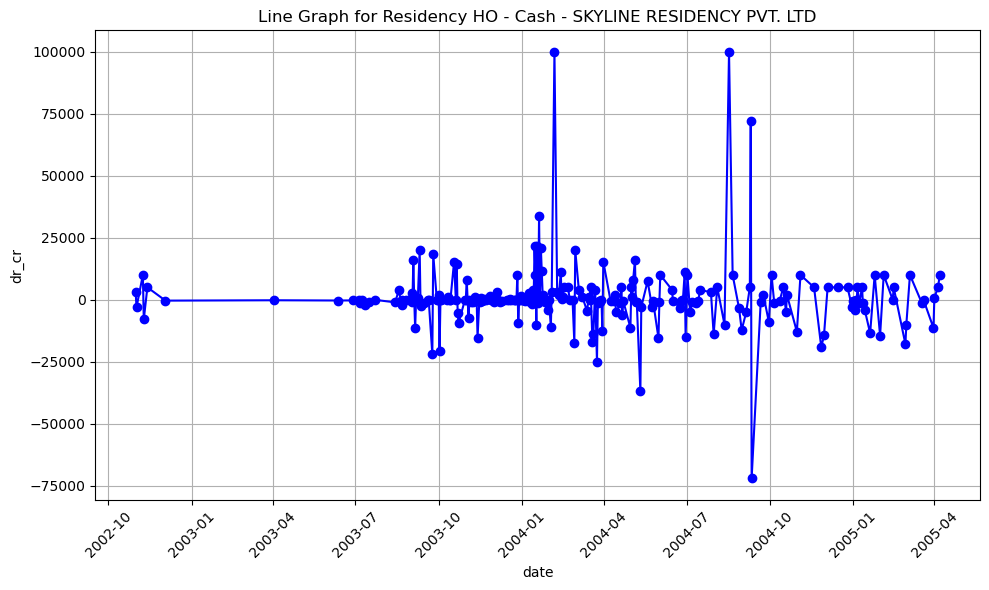

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
df = pd.read_csv('ledger.csv')

# Group by 'project', 'ledger', and 'company', and get the count of rows in each group
grouped_df = df.groupby(['project', 'ledger', 'company']).size()

# Filter groups where the count is greater than 37
filtered_groups = grouped_df[grouped_df > 37]

# Input for the specific group (example: 'Residency HO', 'Cash', 'SKYLINE RESIDENCY PVT. LTD')
input_group = ('Residency HO', 'Cash', 'SKYLINE RESIDENCY PVT. LTD')

# Check if the input group exists in the filtered groups
if input_group in filtered_groups.index:
    # Filter the data for this specific group
    specific_group_data = df[(df['project'] == input_group[0]) & 
                             (df['ledger'] == input_group[1]) & 
                             (df['company'] == input_group[2])]

    if 'date' in specific_group_data.columns and 'dr_cr' in specific_group_data.columns:
        # Convert 'date' column to datetime if necessary
        specific_group_data['date'] = pd.to_datetime(specific_group_data['date'])

        # Sort by date
        specific_group_data.sort_values('date', inplace=True)

        plt.figure(figsize=(10, 6))  # Optional: adjust the figure size
        plt.plot(specific_group_data['date'], specific_group_data['dr_cr'], marker='o', linestyle='-', color='b')

        # Set plot labels and title
        plt.xlabel('date')
        plt.ylabel('dr_cr')
        plt.title(f"Line Graph for {input_group[0]} - {input_group[1]} - {input_group[2]}")

        # Display the plot
        plt.grid(True)
        plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
        plt.tight_layout()  # Adjust layout
        plt.show()
    else:
        print("The required columns 'date' or 'amount' are missing in the dataset.")
else:
    print(f"The group {input_group} is not present in the filtered data.")


Mean Squared Error (MSE): 294641033.8518561
Root Mean Squared Error (RMSE): 17165.11094784581
R-squared (R²): -0.07278617331826087


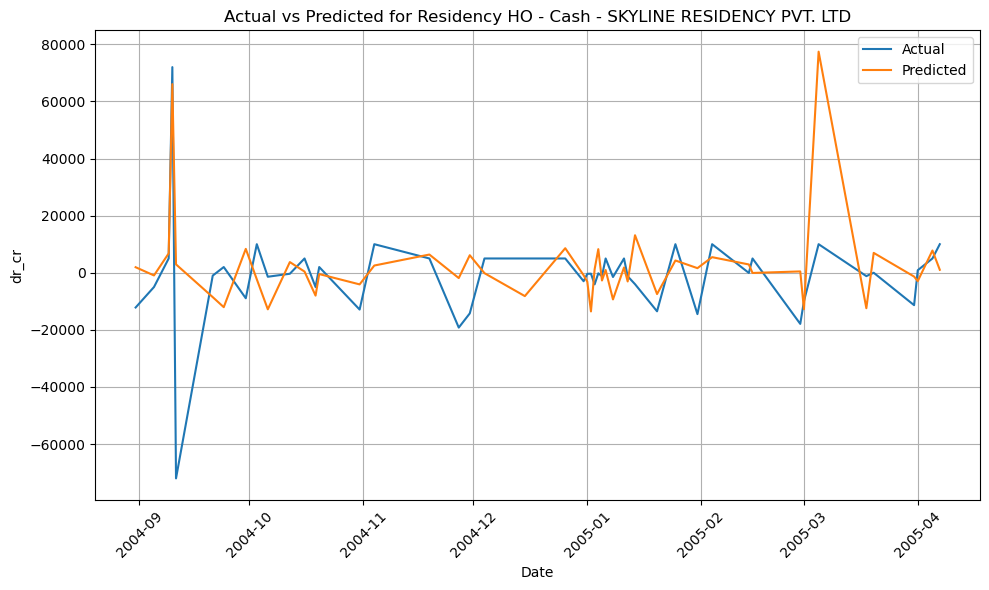

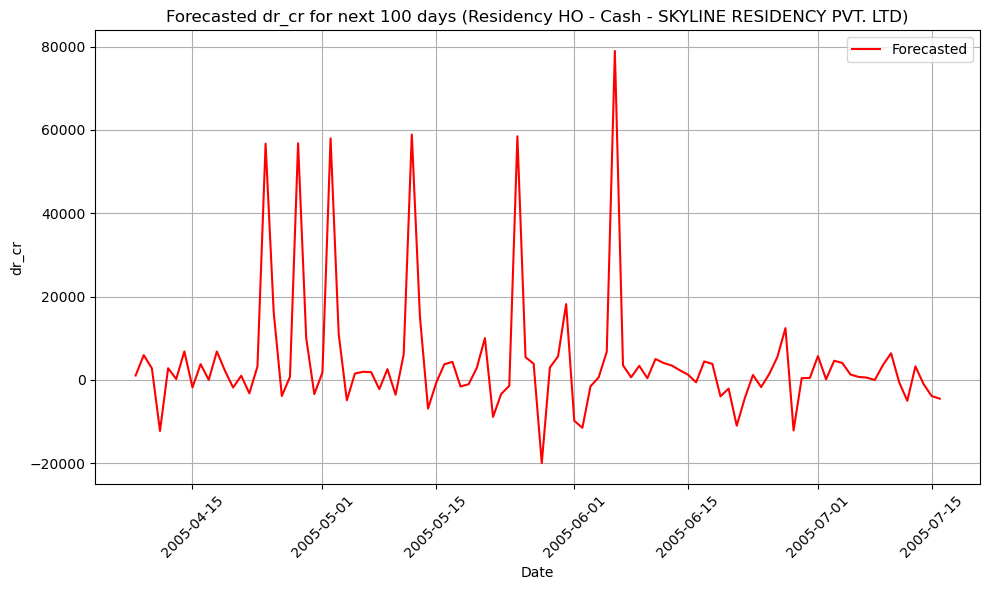

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your CSV file
df = pd.read_csv('ledger.csv')

# Group by 'project', 'ledger', and 'company', and get the count of rows in each group
grouped_df = df.groupby(['project', 'ledger', 'company']).size()

# Filter groups where the count is greater than 37
filtered_groups = grouped_df[grouped_df > 37]

# Input for the specific group (example: 'Residency HO', 'Cash', 'SKYLINE RESIDENCY PVT. LTD')
input_group = ('Residency HO', 'Cash', 'SKYLINE RESIDENCY PVT. LTD')
# input_group = ('Residency HO', 'OTHER LABOUR CHARGES', 'SKYLINE RESIDENCY PVT. LTD')

# Check if the input group exists in the filtered groups
if input_group in filtered_groups.index:
    # Filter the data for this specific group
    specific_group_data = df[(df['project'] == input_group[0]) & 
                             (df['ledger'] == input_group[1]) & 
                             (df['company'] == input_group[2])].copy()  # Ensure a copy of the subset

    if 'date' in specific_group_data.columns and 'dr_cr' in specific_group_data.columns:
        # Convert 'date' column to datetime if necessary
        specific_group_data.loc[:, 'date'] = pd.to_datetime(specific_group_data['date'])

        # Sort by date
        specific_group_data.sort_values('date', inplace=True)

        # Feature engineering: Use 'dr_cr' as the target variable and create lag features for prediction
        specific_group_data.loc[:, 'target'] = specific_group_data['dr_cr']
        for i in range(1, 6):  # Create 5 lag features for example (change this based on your data)
            specific_group_data.loc[:, f'lag_{i}'] = specific_group_data['dr_cr'].shift(i)

        # Drop missing values that result from shifting
        specific_group_data.dropna(inplace=True)

        # Define the features (X) and target (y)
        X = specific_group_data[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]  # Example: 5 lags
        y = specific_group_data['target']

        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Initialize and train the XGBoost model
        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate the MSE, RMSE, and R² values
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"R-squared (R²): {r2}")

        # Plot the original and predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(specific_group_data['date'].iloc[-len(y_test):], y_test, label='Actual')
        plt.plot(specific_group_data['date'].iloc[-len(y_pred):], y_pred, label='Predicted')
        plt.xlabel('Date')
        plt.ylabel('dr_cr')
        plt.title(f"Actual vs Predicted for {input_group[0]} - {input_group[1]} - {input_group[2]}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Now, forecast the next 100 values
        last_data = specific_group_data[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']].iloc[-1].values.reshape(1, -1)
        
        forecast = []
        for i in range(100):
            # Predict the next value
            next_value = model.predict(last_data)[0]
            forecast.append(next_value)
            
            # Update the last_data with the new predicted value for the next iteration
            last_data = np.roll(last_data, shift=-1, axis=1)
            last_data[0, -1] = next_value

        # Plot the forecasted values
        forecast_dates = pd.date_range(start=specific_group_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=100, freq='D')
        plt.figure(figsize=(10, 6))
        plt.plot(forecast_dates, forecast, label='Forecasted', color='r')
        plt.xlabel('Date')
        plt.ylabel('dr_cr')
        plt.title(f"Forecasted dr_cr for next 100 days ({input_group[0]} - {input_group[1]} - {input_group[2]})")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    else:
        print("The required columns 'date' or 'dr_cr' are missing in the dataset.")
else:
    print(f"The group {input_group} is not present in the filtered data.")


Mean Squared Error (MSE): 42969907.90072421
Root Mean Squared Error (RMSE): 6555.143621670254
R-squared (R²): 0.31420725834576446


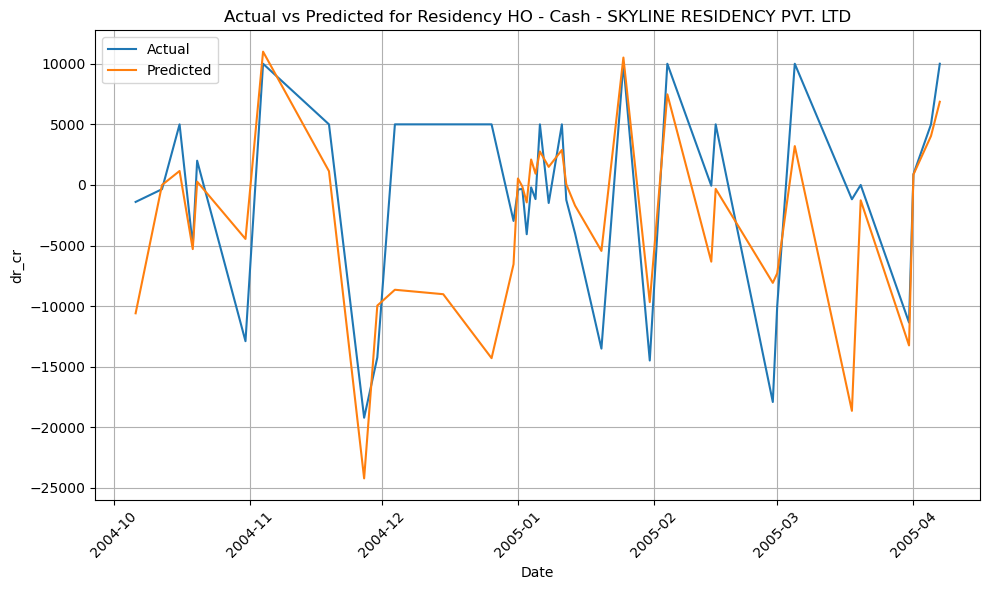

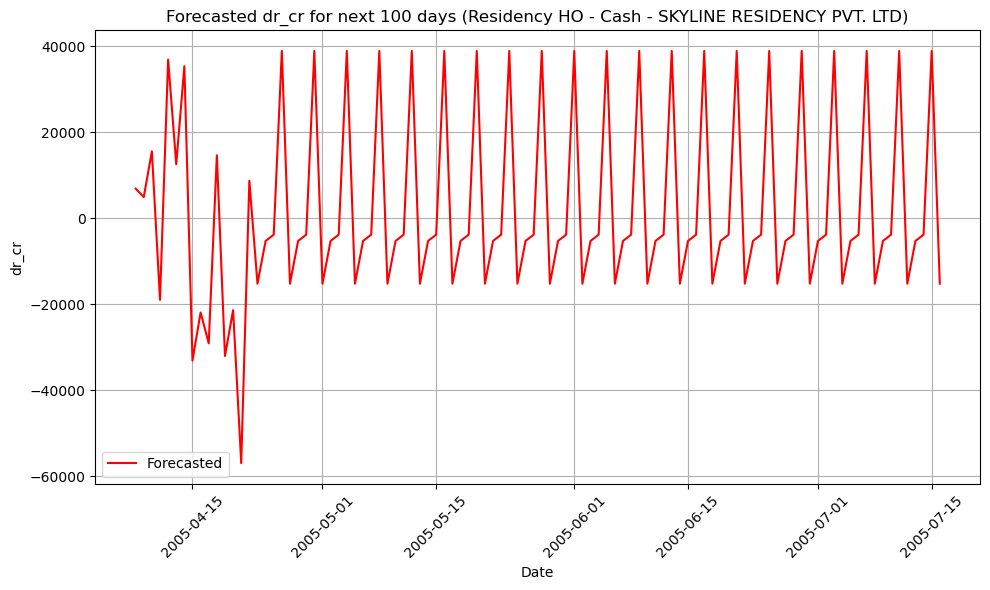

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your CSV file
df = pd.read_csv('ledger.csv')

# Group by 'project', 'ledger', and 'company', and get the count of rows in each group
grouped_df = df.groupby(['project', 'ledger', 'company']).size()

# Filter groups where the count is greater than 37
filtered_groups = grouped_df[grouped_df > 37]

# Input for the specific group
input_group = ('Residency HO', 'Cash', 'SKYLINE RESIDENCY PVT. LTD')
# input_group = ('Residency HO', 'OTHER LABOUR CHARGES', 'SKYLINE RESIDENCY PVT. LTD')

# Check if the input group exists in the filtered groups
if input_group in filtered_groups.index:
    # Filter the data for this specific group
    specific_group_data = df[(df['project'] == input_group[0]) & 
                             (df['ledger'] == input_group[1]) & 
                             (df['company'] == input_group[2])].copy()

    if 'date' in specific_group_data.columns and 'dr_cr' in specific_group_data.columns:
        # Convert 'date' column to datetime
        specific_group_data['date'] = pd.to_datetime(specific_group_data['date'])

        # Sort by date
        specific_group_data.sort_values('date', inplace=True)

        # Feature engineering: Create lag features
        specific_group_data['target'] = specific_group_data['dr_cr']
        for i in range(1, 6):
            specific_group_data[f'lag_{i}'] = specific_group_data['dr_cr'].shift(i)

        # Add rolling statistics
        specific_group_data['rolling_mean'] = specific_group_data['dr_cr'].rolling(window=5).mean()
        specific_group_data['rolling_std'] = specific_group_data['dr_cr'].rolling(window=5).std()

        # Add time-based features
        specific_group_data['day_of_week'] = specific_group_data['date'].dt.dayofweek
        specific_group_data['month'] = specific_group_data['date'].dt.month

        # Drop missing values resulting from shifting and rolling operations
        specific_group_data.dropna(inplace=True)

        # Define the features (X) and target (y)
        feature_columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'rolling_mean', 'rolling_std', 
                           'day_of_week', 'month']
        X = specific_group_data[feature_columns]
        y = specific_group_data['target']

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Time-series split for training and testing
        tscv = TimeSeriesSplit(n_splits=5)
        best_model = None
        best_score = float('-inf')

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'min_child_weight': [1, 3, 5]
        }

        for train_index, test_index in tscv.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), 
                                       param_grid=param_grid, cv=3, scoring='r2')
            grid_search.fit(X_train, y_train)

            # Store the best model from GridSearchCV
            if grid_search.best_score_ > best_score:
                best_model = grid_search.best_estimator_
                best_score = grid_search.best_score_

        # Train the best model on the full dataset
        best_model.fit(X_scaled[:-len(y_test)], y[:-len(y_test)])
        y_pred = best_model.predict(X_scaled[-len(y_test):])

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"R-squared (R²): {r2}")

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(specific_group_data['date'].iloc[-len(y_test):], y_test, label='Actual')
        plt.plot(specific_group_data['date'].iloc[-len(y_pred):], y_pred, label='Predicted')
        plt.xlabel('Date')
        plt.ylabel('dr_cr')
        plt.title(f"Actual vs Predicted for {input_group[0]} - {input_group[1]} - {input_group[2]}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Forecasting the next 100 days
        last_data = X_scaled[-1].reshape(1, -1)
        forecast = []

        for i in range(100):
            next_value = best_model.predict(last_data)[0]
            forecast.append(next_value)

            # Dynamically update the features for the next prediction
            new_features = np.roll(last_data, shift=-1, axis=1)
            new_features[0, -1] = next_value
            last_data = new_features

        # Generate forecast dates
        forecast_dates = pd.date_range(start=specific_group_data['date'].iloc[-1] + pd.Timedelta(days=1), 
                                       periods=100, freq='D')

        # Plot the forecast
        plt.figure(figsize=(10, 6))
        plt.plot(forecast_dates, forecast, label='Forecasted', color='r')
        plt.xlabel('Date')
        plt.ylabel('dr_cr')
        plt.title(f"Forecasted dr_cr for next 100 days ({input_group[0]} - {input_group[1]} - {input_group[2]})")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    else:
        print("The required columns 'date' or 'dr_cr' are missing in the dataset.")
else:
    print(f"The group {input_group} is not present in the filtered data.")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mean Squared Error (MSE): 141536566544.35425
Root Mean Squared Error (RMSE): 376213.4587496229
R-squared (R²): 0.879863150309227


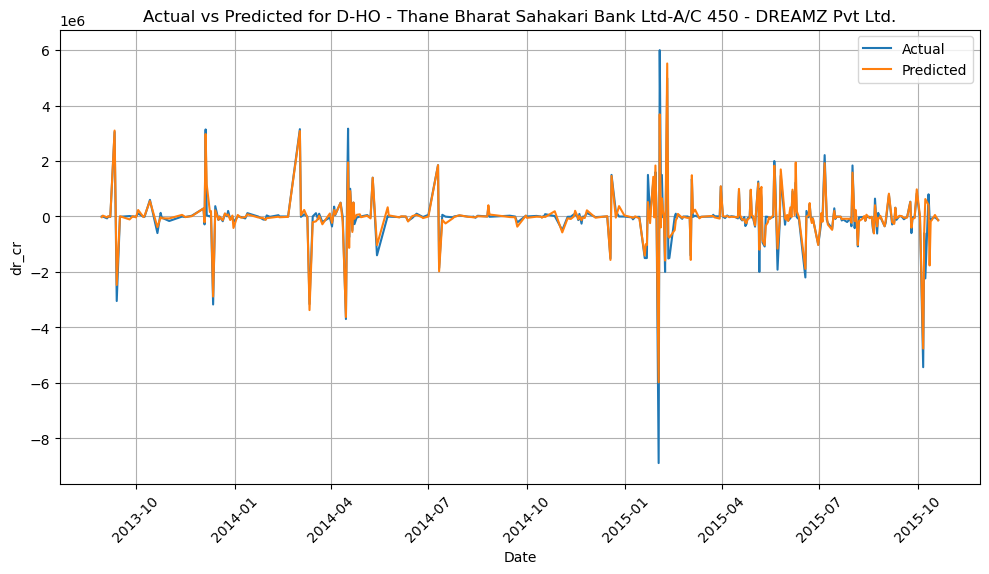

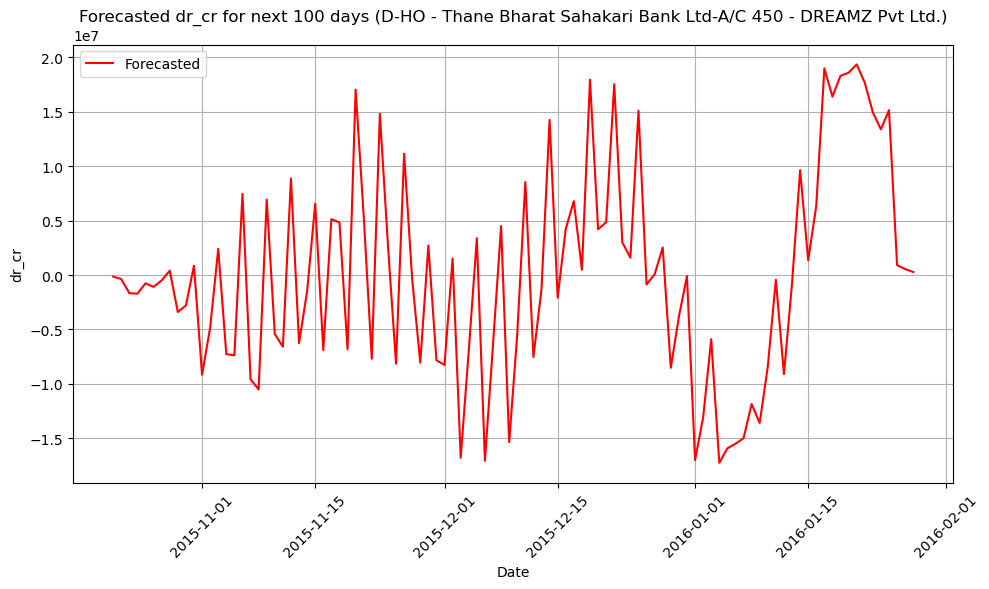

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load your CSV file
df = pd.read_csv('ledger.csv')

# Group by 'project', 'ledger', and 'company', and get the count of rows in each group
grouped_df = df.groupby(['project', 'ledger', 'company']).size()

# Filter groups where the count is greater than 37
filtered_groups = grouped_df[grouped_df > 37]

# Input for the specific group
# input_group = ('Residency HO', 'Cash', 'SKYLINE RESIDENCY PVT. LTD')
input_group = ('D-HO', 'Thane Bharat Sahakari Bank Ltd-A/C 450', 'DREAMZ Pvt Ltd.')

# Check if the input group exists in the filtered groups
if input_group in filtered_groups.index:
    # Filter the data for this specific group
    specific_group_data = df[(df['project'] == input_group[0]) & 
                             (df['ledger'] == input_group[1]) & 
                             (df['company'] == input_group[2])].copy()

    if 'date' in specific_group_data.columns and 'dr_cr' in specific_group_data.columns:
        # Convert 'date' column to datetime if necessary
        specific_group_data.loc[:, 'date'] = pd.to_datetime(specific_group_data['date'])

        # Sort by date
        specific_group_data.sort_values('date', inplace=True)

        # Feature engineering: Use 'dr_cr' as the target variable
        specific_group_data.loc[:, 'target'] = specific_group_data['dr_cr']

        # Add lag features
        num_lags = 10  # Number of lags to create
        for i in range(1, num_lags + 1):
            specific_group_data.loc[:, f'lag_{i}'] = specific_group_data['dr_cr'].shift(i)

        # Add rolling averages
        specific_group_data.loc[:, 'roll_avg_3'] = specific_group_data['dr_cr'].rolling(window=3).mean()
        specific_group_data.loc[:, 'roll_avg_7'] = specific_group_data['dr_cr'].rolling(window=7).mean()
        specific_group_data.loc[:, 'roll_avg_14'] = specific_group_data['dr_cr'].rolling(window=14).mean()

        # Drop missing values that result from shifting and rolling
        specific_group_data.dropna(inplace=True)

        # Define the features (X) and target (y)
        feature_columns = [col for col in specific_group_data.columns if col.startswith('lag_') or col.startswith('roll_avg_')]
        X = specific_group_data[feature_columns]
        y = specific_group_data['target']

        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Hyperparameter tuning for XGBoost
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
        }

        model = XGBRegressor(objective='reg:squarederror')
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
        grid_search.fit(X_train, y_train)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"R-squared (R²): {r2}")

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(specific_group_data['date'].iloc[-len(y_test):], y_test, label='Actual')
        plt.plot(specific_group_data['date'].iloc[-len(y_pred):], y_pred, label='Predicted')
        plt.xlabel('Date')
        plt.ylabel('dr_cr')
        plt.title(f"Actual vs Predicted for {input_group[0]} - {input_group[1]} - {input_group[2]}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Forecast the next 100 days
        last_data = X.iloc[-1].values.reshape(1, -1)
        forecast = []
        for i in range(100):
            next_value = best_model.predict(last_data)[0]
            forecast.append(next_value)

            # Update the last_data with the new predicted value
            last_data = np.roll(last_data, shift=-1, axis=1)
            last_data[0, -1] = next_value

        # Plot the forecasted values
        forecast_dates = pd.date_range(start=specific_group_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=100, freq='D')
        plt.figure(figsize=(10, 6))
        plt.plot(forecast_dates, forecast, label='Forecasted', color='r')
        plt.xlabel('Date')
        plt.ylabel('dr_cr')
        plt.title(f"Forecasted dr_cr for next 100 days ({input_group[0]} - {input_group[1]} - {input_group[2]})")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    else:
        print("The required columns 'date' or 'dr_cr' are missing in the dataset.")
else:
    print(f"The group {input_group} is not present in the filtered data.")